# 🕵️‍♂️ IEEE-CIS Fraud Detection: End-to-End Machine Learning Pipeline

## 📌 Project Overview
Credit card fraud is a major issue faced by financial institutions, resulting in billions of dollars in losses each year.  
This project aims to build a **production-grade machine learning pipeline** to detect fraudulent online transactions using the **IEEE-CIS Fraud Detection dataset** from Kaggle.

The dataset contains anonymized transaction and identity information, with highly imbalanced labels — only ~3.5% of transactions are fraudulent.  
The project focuses on building scalable, interpretable, and deployable fraud detection models that can operate effectively in real-world conditions.

---

## 🎯 Objectives
- Perform **data cleaning, merging, and feature engineering** on large-scale transactional data  
- Handle **imbalanced class distributions** using advanced sampling techniques  
- Train and compare **state-of-the-art ML models** (LightGBM, XGBoost, CatBoost, etc.)  
- Use **SHAP explainability** to understand model predictions and feature importance  
- Deploy the final model using **FastAPI / Streamlit** for real-time inference  

---

## 📊 Dataset Details
**Source:** [Kaggle - IEEE-CIS Fraud Detection](https://www.kaggle.com/competitions/ieee-fraud-detection)  
**Files:**
- `train_transaction.csv` → transaction-level data  
- `train_identity.csv` → device and identity features  
- `isFraud` → target variable (1 = Fraud, 0 = Non-Fraud)

**Shape:**  
- Transactions: ~590,000 rows  
- Features: 394 columns  
- Fraud rate: ~3.5%

---

## ⚙️ Key Challenges
- Extremely **imbalanced dataset** → minority fraud class is <4%  
- Large feature space with **missing and anonymized variables**  
- **Noisy categorical features** (device, email, address info)  
- Need for **efficient memory management** and **fast I/O** due to dataset size  

---

## 🧰 Technologies & Tools
| Category | Tools |
|-----------|--------|
| Language | Python 3.11 |
| Data Processing | Pandas, NumPy, PyArrow |
| Visualization | Matplotlib, Seaborn, Plotly |
| Machine Learning | Scikit-learn, LightGBM, XGBoost, CatBoost |
| Imbalanced Learning | imbalanced-learn (SMOTE, Ensemble Methods) |
| Explainability | SHAP |
| Deployment | FastAPI, Streamlit, Docker |
| Optimization | Optuna |

---

## 🧩 Project Workflow
1. **Data Loading & Merging** → Combine transaction & identity datasets  
2. **Exploratory Data Analysis (EDA)** → Understand structure, missing values, correlations  
3. **Feature Engineering** → Create meaningful aggregated, encoded, and temporal features  
4. **Preprocessing Pipeline** → Scaling, encoding, and resampling (SMOTE, class weights)  
5. **Model Training & Evaluation** → Compare multiple classifiers with AUC-ROC, F1, PR Curve  
6. **Model Explainability** → Interpret predictions with SHAP  
7. **Deployment** → Serve predictions through API / Streamlit dashboard  

---

## 🧠 Expected Outcome
By the end of this project, we’ll have a **robust, explainable fraud detection model** capable of identifying suspicious transactions with high recall and interpretability.  
This end-to-end pipeline will demonstrate the **skills of a production-ready AI/ML Engineer**, including data engineering, model building, and deployment.

---  

## Step 1: Imports and Environment Setup

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

In [10]:
from sklearn.model_selection import train_test_split,cross_val_score,StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler

In [11]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [12]:
from sklearn.metrics import (
    roc_auc_score,
    confusion_matrix,
    classification_report,
    precision_recall_curve,
    roc_curve,
    precision_score,
    recall_score,
    f1_score,
)

In [13]:
from tqdm import tqdm
from datetime import datetime
import time
import sys

In [14]:
import shap

##  Step 2: Data Loading and Merging

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_transaction = pd.read_csv("/content/drive/MyDrive/IEEE-Fraud-detection/train_transaction.csv")
train_identity = pd.read_csv("/content/drive/MyDrive/IEEE-Fraud-detection/train_identity.csv")
test_transaction = pd.read_csv("/content/drive/MyDrive/IEEE-Fraud-detection/test_transaction.csv")
test_identity = pd.read_csv("/content/drive/MyDrive/IEEE-Fraud-detection/test_identity.csv")

In [ ]:
print(f"train_transacrtion shape = {train_transaction.shape}")
print(f"train_identity shape = {train_identity.shape}")
print(f"test_transaction shape = {test_transaction.shape}")
print(f"test_identity shape = {test_identity.shape}")

train_transacrtion shape = (590540, 394)
train_identity shape = (144233, 41)
test_transaction shape = (506691, 393)
test_identity shape = (141907, 41)


In [ ]:
print("Merging train_transaction and train_identity...")
train = pd.merge(train_transaction,train_identity,on="TransactionID",how="left")

Merging train_transaction and train_identity...


In [ ]:
print("Merging test_transaction and test_identity...")
test = pd.merge(test_transaction, test_identity, on="TransactionID", how="left")

Merging test_transaction and test_identity...


In [ ]:
print(f"Final train shape: {train.shape}")
print(f"Final test shape: {test.shape}")

Final train shape: (590540, 434)
Final test shape: (506691, 433)


In [ ]:
del train_transaction, train_identity, test_transaction, test_identity

## Step 3. Exploratary Data Analysis(EDA)

In [ ]:
train.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590540 entries, 0 to 590539
Columns: 434 entries, TransactionID to DeviceInfo
dtypes: float64(399), int64(4), object(31)
memory usage: 1.9+ GB


In [ ]:
train.tail()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
590535,3577535,0,15811047,49.00,W,6550,NaN,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590536,3577536,0,15811049,39.50,W,10444,225.0,150.0,mastercard,224.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590537,3577537,0,15811079,30.95,W,12037,595.0,150.0,mastercard,224.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590538,3577538,0,15811088,117.00,W,7826,481.0,150.0,mastercard,224.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590539,3577539,0,15811131,279.95,W,15066,170.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
train.dtypes

,0
TransactionID,int64
isFraud,int64
TransactionDT,int64
TransactionAmt,float64
ProductCD,object
...,...
id_36,object
id_37,object
id_38,object
DeviceType,object


In [ ]:
train.isna().sum().sort_values(ascending=False).head(15)

,0
id_24,585793
id_25,585408
id_07,585385
id_08,585385
id_21,585381
id_26,585377
id_27,585371
id_23,585371
id_22,585371
dist2,552913


In [ ]:
train.isna().sum().sum()

np.int64(115523073)

In [ ]:
train["isFraud"].value_counts()

,count
isFraud,
0,569877
1,20663


In [ ]:
train.head().T

,0,1,2,3,4
TransactionID,2987000,2987001,2987002,2987003,2987004
isFraud,0,0,0,0,0
TransactionDT,86400,86401,86469,86499,86506
TransactionAmt,68.5,29.0,59.0,50.0,50.0
ProductCD,W,W,W,W,H
...,...,...,...,...,...
id_36,NaN,NaN,NaN,NaN,F
id_37,NaN,NaN,NaN,NaN,T
id_38,NaN,NaN,NaN,NaN,T
DeviceType,NaN,NaN,NaN,NaN,mobile


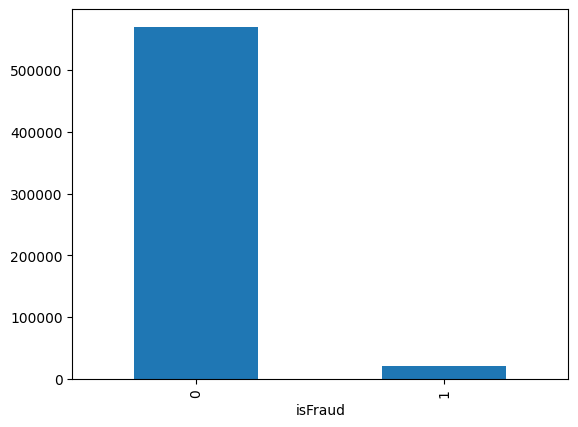

In [ ]:
train["isFraud"].value_counts().plot(kind="bar")
plt.show()

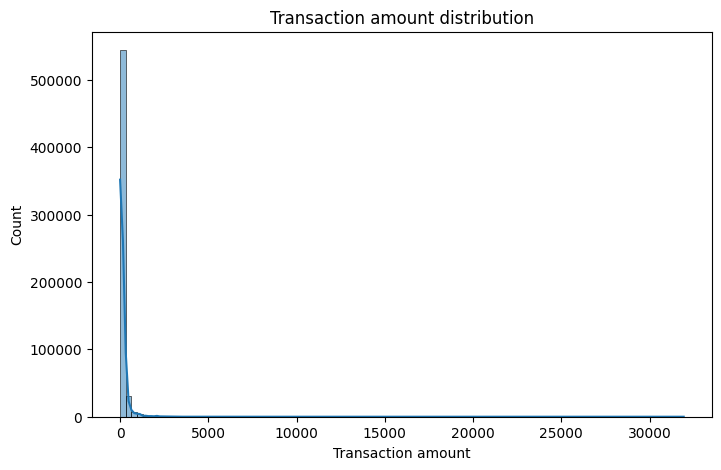

In [ ]:
plt.figure(figsize =(8,5))
sns.histplot(train["TransactionAmt"],bins=100,kde =True)
plt.title("Transaction amount distribution")
plt.xlabel("Transaction amount")
plt.ylabel("Count")
plt.show()

Text(0.5, 1.0, 'Transaction amount by fraud status')

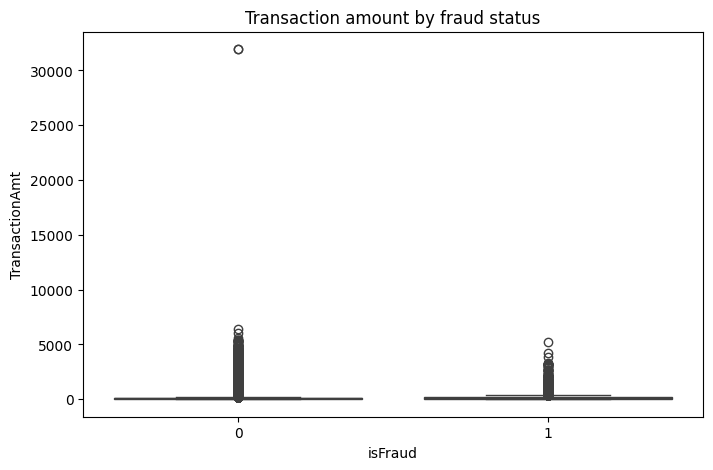

In [ ]:
plt.figure(figsize=(8,5))
sns.boxplot(x="isFraud",y ="TransactionAmt",data = train)
plt.title("Transaction amount by fraud status")

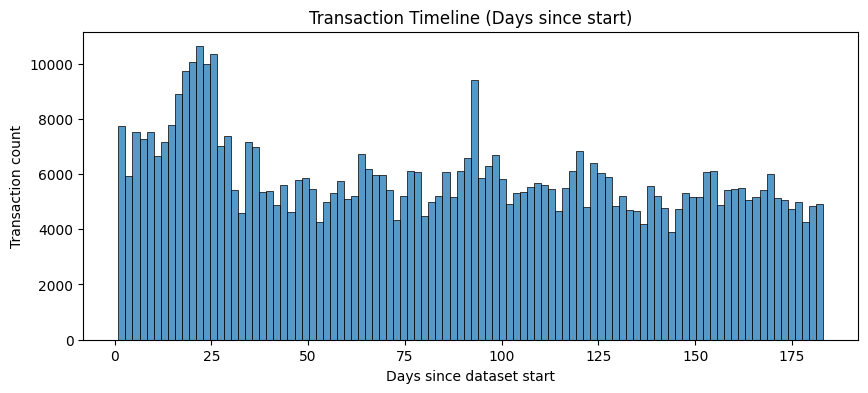

In [ ]:
plt.figure(figsize=(10,4))
sns.histplot(train['TransactionDT']/24/60/60, bins=100, kde=False)
plt.title("Transaction Timeline (Days since start)")
plt.xlabel("Days since dataset start")
plt.ylabel("Transaction count")
plt.show()


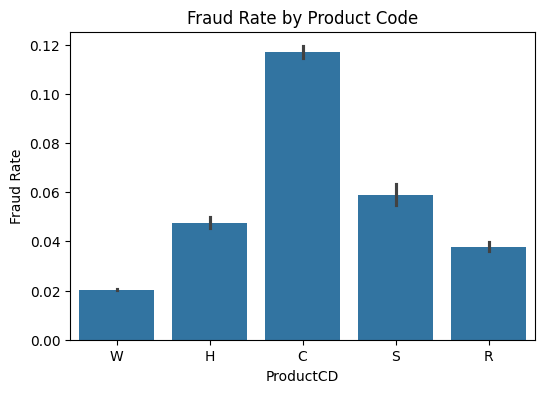

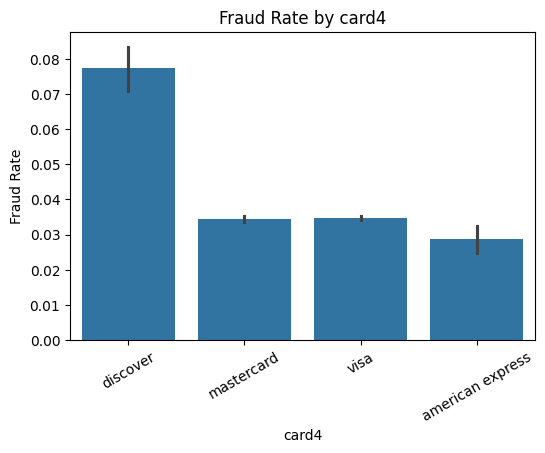

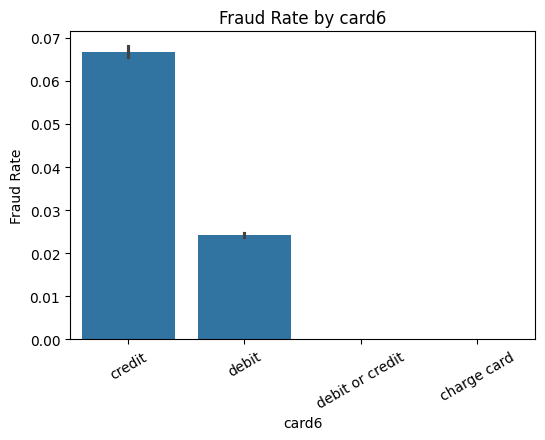

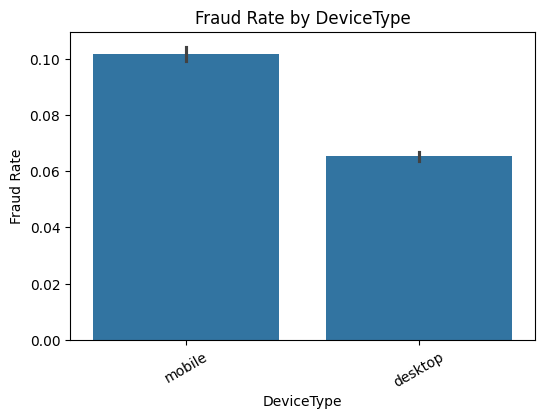

In [ ]:
plt.figure(figsize=(6,4))
sns.barplot(x='ProductCD', y='isFraud', data=train, estimator=lambda x: sum(x)/len(x))
plt.title("Fraud Rate by Product Code")
plt.ylabel("Fraud Rate")
plt.show()

# Card networks, device types
for col in ['card4', 'card6', 'DeviceType']:
    if col in train.columns:
        plt.figure(figsize=(6,4))
        sns.barplot(x=col, y='isFraud', data=train, estimator=lambda x: sum(x)/len(x))
        plt.title(f"Fraud Rate by {col}")
        plt.ylabel("Fraud Rate")
        plt.xticks(rotation=30)
        plt.show()


Email columns: ['P_emaildomain', 'R_emaildomain']


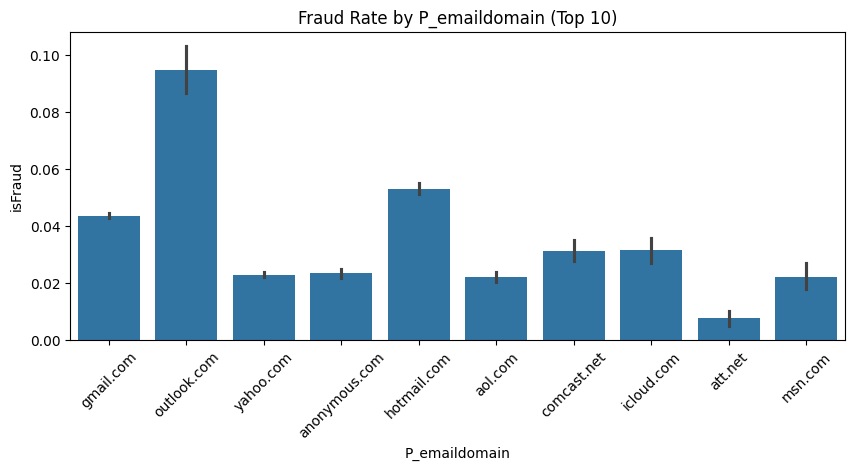

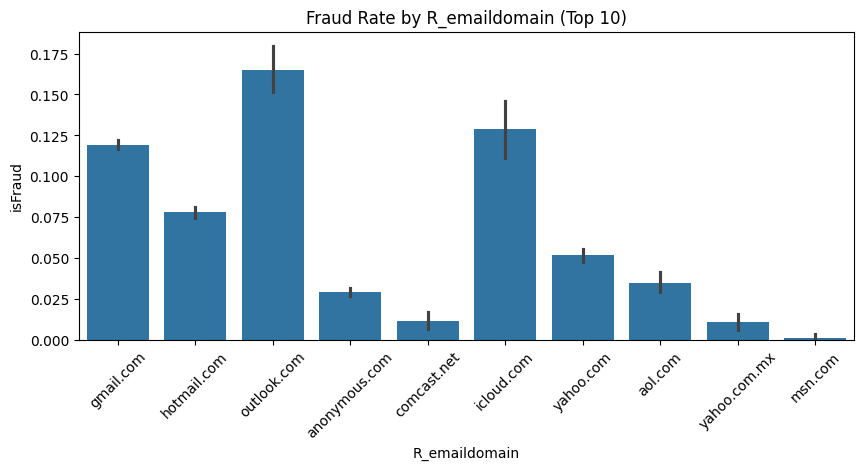

In [ ]:
email_cols = [c for c in train.columns if 'email' in c.lower()]
print("Email columns:", email_cols)

for col in email_cols:
    plt.figure(figsize=(10,4))
    top_emails = train[col].value_counts().nlargest(10).index
    sns.barplot(
        x=col, y='isFraud',
        data=train[train[col].isin(top_emails)],
        estimator=lambda x: sum(x)/len(x)
    )
    plt.title(f"Fraud Rate by {col} (Top 10)")
    plt.xticks(rotation=45)
    plt.show()


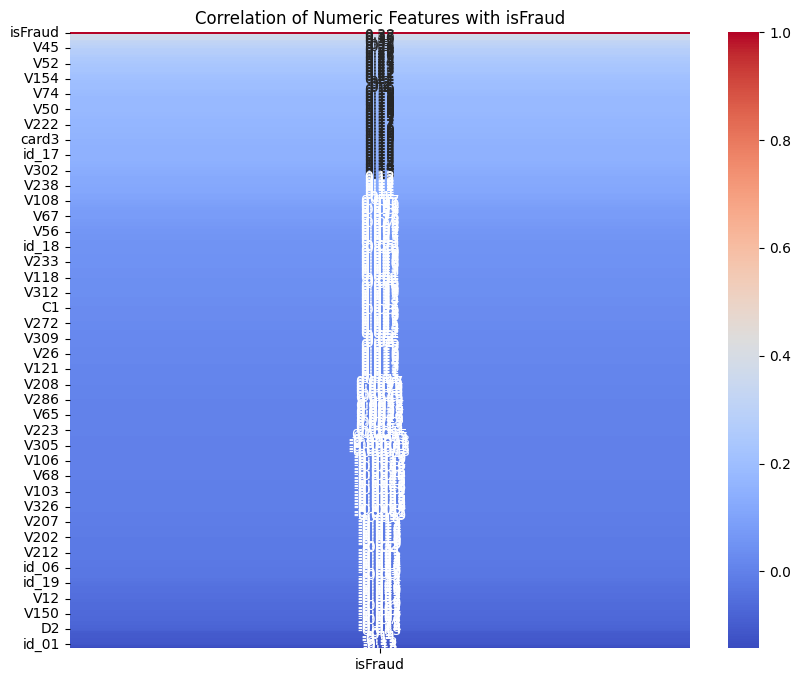

In [ ]:
numeric_sample = train.select_dtypes("number").corr()
plt.figure(figsize = (10,8))
sns.heatmap(numeric_sample[["isFraud"]].sort_values(by="isFraud",ascending= False),annot =True,cmap="coolwarm")
plt.title("Correlation of Numeric Features with isFraud")
plt.show()

In [ ]:
fraud_summary = train.groupby('isFraud')['TransactionAmt'].agg(['mean','median','max','min'])
display(fraud_summary)


,mean,median,max,min
isFraud,,,,
0,134.511665,68.5,31937.391,0.251
1,149.244779,75.0,5191.000,0.292


## Step 4. Data Cleaning and Preprocessing

In [ ]:
X = train.drop(columns=["isFraud","TransactionID"])
y = train["isFraud"]

In [ ]:
missing_ratio = X.isna().sum()/len(X)
high_missing_cols = missing_ratio[missing_ratio>0.9].index
X = X.drop(columns=high_missing_cols)
test = test.drop(columns=high_missing_cols,errors = "ignore")

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [ ]:
num_cols = X_train.select_dtypes(include=["int64", "float64"]).columns
cat_cols = X_train.select_dtypes(include=["object"]).columns

In [ ]:
skewness = X[num_cols].skew().abs()
mean_cols = skewness[skewness<0.5].index.tolist()
median_cols = skewness[skewness>=0.5].index.tolist()

In [ ]:
mean_transformer = Pipeline(steps=[
    ("imputer",SimpleImputer(strategy="mean")),
    ("scaler",StandardScaler())
])
median_transformer = Pipeline(steps=[
    ("imputer",SimpleImputer(strategy="median")),
    ("scaler",StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ("imputer",SimpleImputer(strategy="most_frequent")),
    ("encoder",OneHotEncoder(handle_unknown="ignore",sparse_output=False))
])
preprocessor = ColumnTransformer(
    transformers=[
    ('mean',mean_transformer,mean_cols),
    ('median',median_transformer,median_cols),
    ('cat',categorical_transformer,cat_cols)
])
preprocessing_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])

X_train_processed = preprocessing_pipeline.fit_transform(X_train)
X_val_processed = preprocessing_pipeline.transform(X_val)

print(f"Processed X_train shape: {X_train_processed.shape}")

Processed X_train shape: (472432, 2688)


In [ ]:
type(X_train_processed), X_train_processed.shape


(numpy.ndarray, (472432, 2688))

In [4]:
import numpy as np

X_train = np.load('/content/drive/MyDrive/X_train_processed.npy')
X_val = np.load('/content/drive/MyDrive/X_val_processed.npy')
y_train = np.load('/content/drive/MyDrive/y_train.npy')
y_val = np.load('/content/drive/MyDrive/y_val.npy')

print(X_train.shape, X_val.shape)


(472432, 2688) (118108, 2688)


## 5. Model training

In [43]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=500, class_weight='balanced', n_jobs=-1),
    "Random Forest": RandomForestClassifier(n_estimators=200, max_depth=12, n_jobs=-1),
    "XGBoost": XGBClassifier(n_estimators=300, max_depth=7, learning_rate=0.1, tree_method='hist', device='cuda'),
    "LightGBM": LGBMClassifier(n_estimators=300, max_depth=-1, learning_rate=0.1)
}

In [ ]:
results = []
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

for name, model in models.items():
    print(f"🔹 Training {name}...")

    model_pipeline = Pipeline(steps=[
        ('classifier', model)
    ])

    model_pipeline.fit(X_train[:100000], y_train[:100000])

    y_pred_proba = model_pipeline.predict_proba(X_val)[:, 1]
    roc_auc = roc_auc_score(y_val, y_pred_proba)

    cv_scores = cross_val_score(model_pipeline, X_train[:100000], y_train[:100000],
                                cv=cv, scoring='roc_auc', n_jobs=-1)

    results.append({
        'Model': name,
        'Validation ROC-AUC': round(roc_auc, 4),
        'CV ROC-AUC': round(cv_scores.mean(), 4)
    })
results_df = pd.DataFrame(results).sort_values(by='Validation ROC-AUC', ascending=False)
print("\nModel Performance Summary:")
display(results_df)


🔹 Training Logistic Regression...
🔹 Training Random Forest...
🔹 Training XGBoost...
🔹 Training LightGBM...
[LightGBM] [Info] Number of positive: 3498, number of negative: 96502
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.117740 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 34621
[LightGBM] [Info] Number of data points in the train set: 100000, number of used features: 715
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.034980 -> initscore=-3.317372
[LightGBM] [Info] Start training from score -3.317372


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



Model Performance Summary:


,Model,Validation ROC-AUC,CV ROC-AUC
3,LightGBM,0.9283,0.9162
2,XGBoost,0.9277,0.9172
1,Random Forest,0.8665,0.8662
0,Logistic Regression,0.8636,0.8560


In [44]:

xgb = XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',
    tree_method='hist',
    device='cuda',
    n_jobs=-1,
    random_state=42,
    scale_pos_weight=10
)

xgb.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='cuda', early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=-1, num_parallel_tree=None, ...)

In [45]:

y_pred_proba = xgb.predict_proba(X_val)[:, 1]
y_pred = (y_pred_proba >= 0.5).astype(int)

roc_auc = roc_auc_score(y_val, y_pred_proba)
print(f"Validation ROC-AUC: {roc_auc:.4f}")

print("\nClassification Report:")
print(classification_report(y_val, y_pred))


Validation ROC-AUC: 0.9408

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98    113975
           1       0.50      0.71      0.59      4133

    accuracy                           0.97    118108
   macro avg       0.75      0.84      0.79    118108
weighted avg       0.97      0.97      0.97    118108



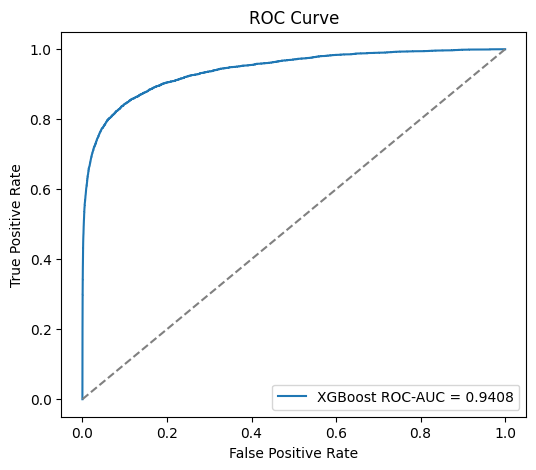

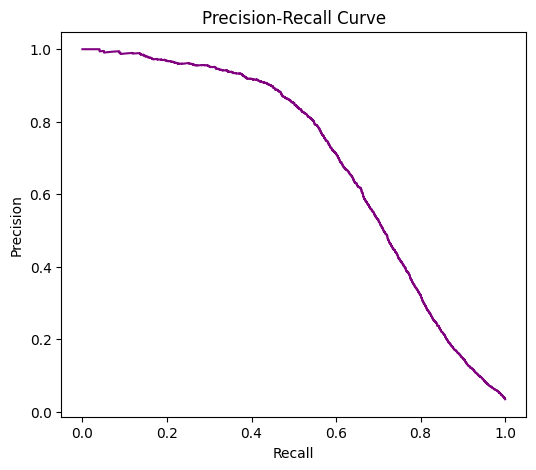

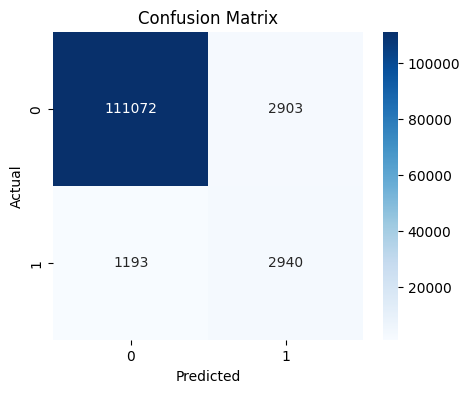

In [46]:
from sklearn.metrics import roc_curve, precision_recall_curve, confusion_matrix, RocCurveDisplay, PrecisionRecallDisplay
import matplotlib.pyplot as plt
import seaborn as sns

# Predict probabilities and classes
y_pred_proba = xgb.predict_proba(X_val)[:, 1]
y_pred = (y_pred_proba >= 0.5).astype(int)

# --- ROC Curve ---
fpr, tpr, _ = roc_curve(y_val, y_pred_proba)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"XGBoost ROC-AUC = {roc_auc:.4f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# --- Precision-Recall Curve ---
precision, recall, _ = precision_recall_curve(y_val, y_pred_proba)
plt.figure(figsize=(6, 5))
plt.plot(recall, precision, color="purple")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.show()

# --- Confusion Matrix ---
cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


<Figure size 800x1000 with 0 Axes>

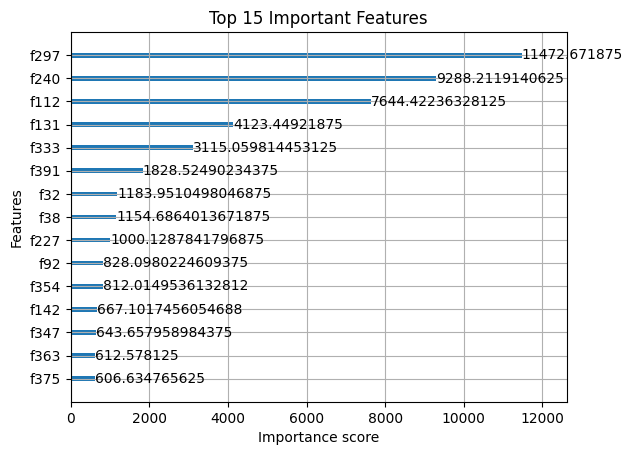

In [47]:
from xgboost import plot_importance

plt.figure(figsize=(8, 10))
plot_importance(xgb, max_num_features=15, importance_type='gain', title='Top 15 Important Features')
plt.show()


In [48]:
import joblib
joblib.dump(xgb, '/content/drive/MyDrive/tuned_xgb_model.pkl')
print("✅ XGBoost model retrained and saved successfully!")


✅ XGBoost model retrained and saved successfully!
